In [2]:
from pystac import ItemCollection
from pystac_client import Client

#bbox = [29.242740, -0.807347, 29.629208, -0.591585]
bbox = [29.296298, -1.582263, 29.769293, -1.197520]

max_cloud_cover = 30
stac_date_format = '%Y-%m-%dT%H:%M:%SZ'
stac_date_string = "2020-01-01T00:00:00/2020-03-01T00:00:00"

client = Client.open("https://earth-search.aws.element84.com/v0")

search = client.search(
    bbox=bbox,
    collections=['sentinel-s2-l2a-cogs'], 
    datetime=stac_date_string,
    sortby='-properties.datetime',
    query={
        "eo:cloud_cover":{
            "lt": str(max_cloud_cover)
        },
    },
)

print(f"{search.matched()} items found")

# limit number of images per Sentinel grid square
limit = 8
items, items_count = [], {}
for item in list(search.items()):
    square = item.properties['sentinel:grid_square']
    count = items_count.get(square, 0)
    if count < limit:
        items.append(item)
        items_count[square] = count + 1

print(f'\t{items_count}')

collection = ItemCollection(items=items)

collection.save_object('./testingCloudMask/l1c_collection.json')


3 items found
	{'RU': 2, 'QU': 1}


In [3]:
%%time

%run _downloads.ipynb

composites = get_processed_composites(collection, bbox, "./testingCloudMask", overwriteDownload=False, overwriteProcessing=False)

	downloading... S2A_35MRU_20200212_0_L2A
	downloading... S2B_35MQU_20200207_0_L2A
	downloading... S2B_35MRU_20200207_0_L2A
	masking... S2A_35MRU_20200212_0_L2A
	masking... S2B_35MQU_20200207_0_L2A
	masking... S2B_35MRU_20200207_0_L2A
	stacking... B02
	compositing... B02
	stacking... B03
	compositing... B03
	stacking... B04
	compositing... B04
	stacking... B08
	compositing... B08
CPU times: user 14.9 s, sys: 7.62 s, total: 22.6 s
Wall time: 55.2 s


In [4]:
all_band_paths = list(composites.values())
rgb_band_paths = [composites['B04'], composites['B03'], composites['B02']]

all_uint16_vrt_path = f'./testingCloudMask/all_uint16.vrt'
create_vrt(all_band_paths, all_uint16_vrt_path)

all_byte_vrt_path = f'./testingCloudMask/all_byte.vrt'
create_byte_vrt(all_uint16_vrt_path, all_byte_vrt_path)

all_byte_cog_path = f'./testingCloudMask/all_byte_cog.tif'
create_tif(all_byte_vrt_path, all_byte_cog_path, isCog=True)

rgb_uint16_vrt_path = f'./testingCloudMask/rgb_uint16.vrt'
create_vrt(rgb_band_paths, rgb_uint16_vrt_path)

rgb_byte_vrt_path = f'./testingCloudMask/rgb_byte.vrt'
create_byte_vrt(rgb_uint16_vrt_path, rgb_byte_vrt_path)

rgb_byte_tif_path = f'./testingCloudMask/rgb_byte_cog.tif'
create_tif(rgb_byte_vrt_path, rgb_byte_tif_path, isCog=True)


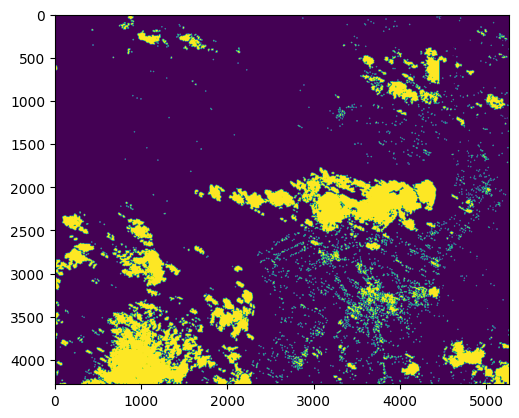

In [24]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

b08_composite = "./testingCloudMask/B08_composite.tif"
data = rasterio.open(b08_composite).read(1, masked=True)

mask = data.mask
plt.imshow(mask)
plt.show()

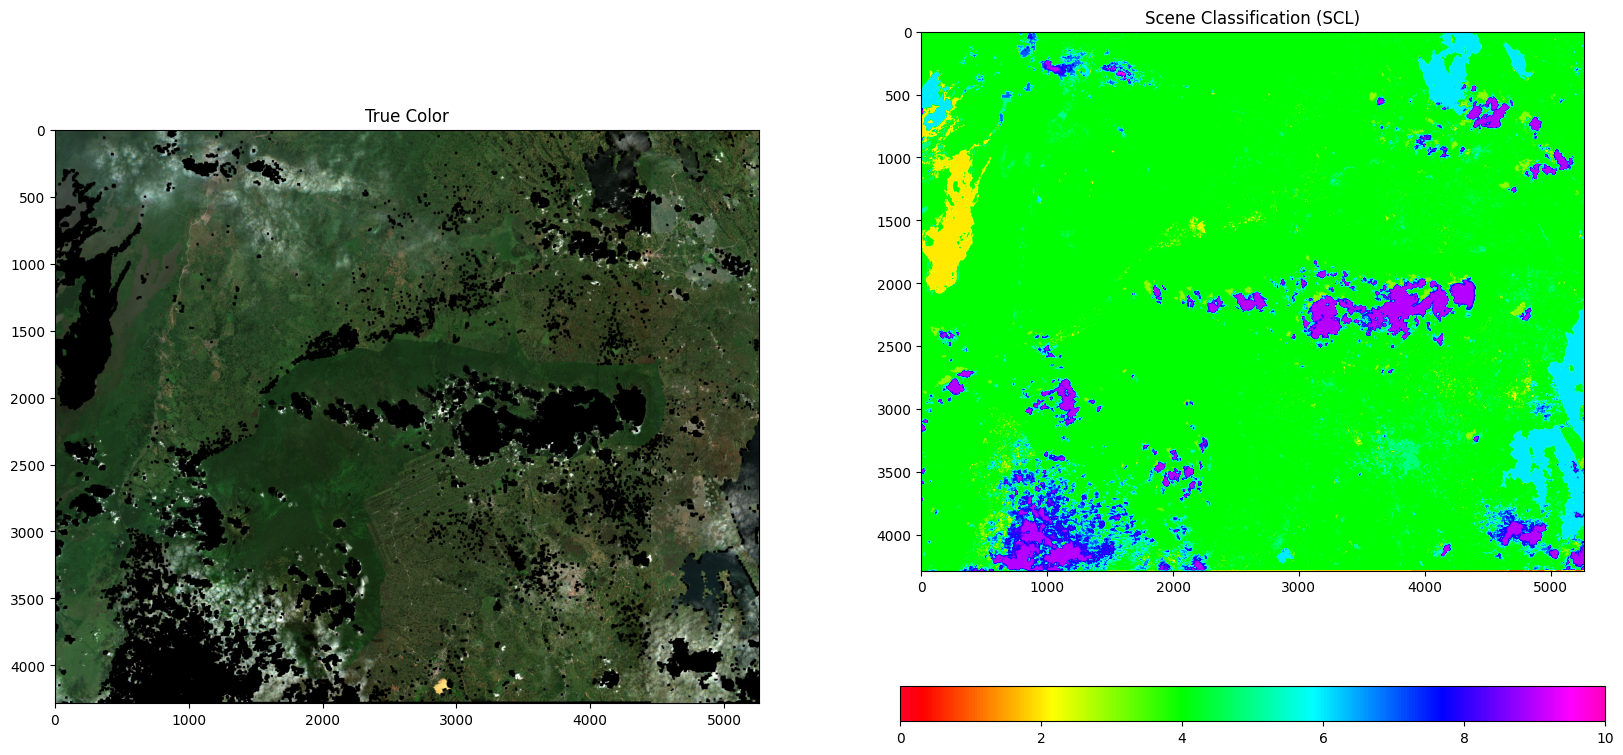

In [88]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

scl_path = "./testing2/S2B_35MQU_20200207_0_L2A//SCL.tif"


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


show(rasterio.open(rgb_byte_tif_path).read(), ax=ax1)
ax1.set_title("True Color")

show(rasterio.open(scl_path).read(1), ax=ax2, cmap='gist_rainbow')
scl_im = ax2.get_images()[0]
plt.colorbar(scl_im, ax=ax2, orientation="horizontal")
ax2.set_title("Scene Classification (SCL)")


plt.show()

In [172]:
import numpy as np
from scipy.ndimage import distance_transform_edt, shift


cloud_mask = np.array([
    [False, False, False, False, False],
    [False, True, True, False, False],
    [False, False, True,  False, False],
    [False, False, False, False, False],
    [False, False, False, False, False],
])


azimuth = 315
zenith = 20
cloud_heights = np.arange(400, 1200, 200) 
scale = 100

azimuth_rad = np.deg2rad(azimuth)
zenith_rad = np.deg2rad(zenith)

def get_potential_shadow(cloud_height):

    shadow_vector = round(np.tan(zenith_rad) * cloud_height)

    x_shift = round(np.cos(azimuth_rad) * shadow_vector / scale)
    y_shift = round(np.sin(azimuth_rad) * shadow_vector / scale)

    print('x_shift:', x_shift, ', y_shift:', y_shift)

    # TODO: check if negatives working... I don't think they are...

    shadows = np.roll(cloud_mask, y_shift, axis=0)
    shadows = np.roll(shadows, x_shift, axis=1)
    
    if x_shift > 0:
        shadows[:, :x_shift] = False
    elif x_shift < 0:
        shadows[:, x_shift:] = False

    if y_shift > 0:
        shadows[:y_shift, :] = False
    elif y_shift < 0:
        shadows[y_shift:, :] = False
    
    print(shadows)
    
    return shadows




shadow_vector: 146
x_shift: 10 , y_shift: -10


In [10]:
import matplotlib.pyplot as plt
import rasterio

def plot_image(data, dst_path, cmap="RdYlGn"):
    plt.imshow(data, cmap=cmap, interpolation="nearest")
    plt.savefig(dst_path)
    plt.clf()


def plot_tif(tif_path, dst_path, bands=1, cmap=None):
    
    with rasterio.open(tif_path) as src:
        data = src.read(bands, masked=True)
        
    if type(bands) == list:
        data = data.transpose((1, 2, 0))
        
    print(data.shape)

    plot_image(data, dst_path, cmap=cmap)


In [11]:
nir_tif = "./testingCloudMask/B08_composite.tif"

plot_tif(nir_tif, "./testingCloudMask/nirPlot.png", bands=[1])

(4283, 5265, 1)


<Figure size 640x480 with 0 Axes>

In [17]:
all_tif = "./testingCloudMask/all_byte_cog.tif"

plot_tif(all_tif, "./testingCloudMask/rgbPlot.png", bands=[3, 2, 2], cmap=None)

(4283, 5265, 3)


<Figure size 640x480 with 0 Axes>